In [6]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import eli5

%matplotlib inline

from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression
# f_regression
#from sklearn.svm import LinearSVR

from eli5.sklearn import PermutationImportance


### Supporting Functions

In [7]:
def get_mse_score(model, X, y, cv=10): # 10-fold cross-validation
    """
    Fit supplied model using X and y using K-fold cross validation. Default K-fold value is 10
    """
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=cv) 
    rmse_score = np.sqrt(-scores)
    #print("Scores: ", rmse_score)
    print("MSE - Mean: ", rmse_score.mean()," - Standard deviation: ", rmse_score. std())
    return rmse_score
    
    
def get_R2_score(X_train, X_valid, y_train, y_valid):
    """
    Fit linear regression model using training data and print R^2 for both training and validation data supplied
    """
    model = LinearRegression()
    model.fit(X_train, y_train)
    print("R^2 for training data: ", model.score(X_train, y_train))
    print("R^2 for validation data: ", model.score(X_valid, y_valid))    
    
    
    
def get_mse_score_tv(model, X_train, X_valid, y_train, y_valid):
    """
    Fit supplied model using training data and print mean_squared_error score for both training and validation data supplied
    """
    model.fit(X_train, y_train)
    y_train_predict = model.predict(X_train)
    y_valid_predict = model.predict(X_valid)
    print("MSE for training data: ", mean_squared_error(y_train, y_train_predict))
    print("MSE for validation data: ", mean_squared_error(y_valid, y_valid_predict))  

# 1. Load Data

In [8]:
data_path = os.path.join("data\\raw\\MtCars.csv")
data_all = pd.read_csv(data_path)

# 2. Data Structure

In [9]:
data_all.head()

,car,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [10]:
data_all.info() #data_all.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   car     32 non-null     object 
 1   mpg     32 non-null     float64
 2   cyl     32 non-null     int64  
 3   disp    32 non-null     float64
 4   hp      32 non-null     int64  
 5   drat    32 non-null     float64
 6   wt      32 non-null     float64
 7   qsec    32 non-null     float64
 8   vs      32 non-null     int64  
 9   am      32 non-null     int64  
 10  gear    32 non-null     int64  
 11  carb    32 non-null     int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 2.9+ KB


>The "car" column is text; everything else is numerical.

> No null values

In [11]:
data_all.isna().sum()

car     0
mpg     0
cyl     0
disp    0
hp      0
drat    0
wt      0
qsec    0
vs      0
am      0
gear    0
carb    0
dtype: int64

> No missing value

In [12]:
data_all['car'].value_counts()

Merc 240D              1
Merc 230               1
Ferrari Dino           1
Fiat 128               1
Cadillac Fleetwood     1
Merc 450SE             1
Maserati Bora          1
Toyota Corona          1
AMC Javelin            1
Merc 280C              1
Lincoln Continental    1
Merc 450SLC            1
Mazda RX4              1
Lotus Europa           1
Merc 450SL             1
Hornet 4 Drive         1
Duster 360             1
Ford Pantera L         1
Pontiac Firebird       1
Toyota Corolla         1
Mazda RX4 Wag          1
Porsche 914-2          1
Volvo 142E             1
Hornet Sportabout      1
Valiant                1
Datsun 710             1
Chrysler Imperial      1
Honda Civic            1
Fiat X1-9              1
Camaro Z28             1
Merc 280               1
Dodge Challenger       1
Name: car, dtype: int64

> The data in the "car" column does not carry any significant information since it is following unity distribution. Hence this data can be discarded.

In [13]:
data_all.describe()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.0000
mean,20.090625,6.187500,230.721875,146.687500,3.596563,3.217250,17.848750,0.437500,0.406250,3.687500,2.8125
std,6.026948,1.785922,123.938694,68.562868,0.534679,0.978457,1.786943,0.504016,0.498991,0.737804,1.6152
min,10.400000,4.000000,71.100000,52.000000,2.760000,1.513000,14.500000,0.000000,0.000000,3.000000,1.0000
25%,15.425000,4.000000,120.825000,96.500000,3.080000,2.581250,16.892500,0.000000,0.000000,3.000000,2.0000
50%,19.200000,6.000000,196.300000,123.000000,3.695000,3.325000,17.710000,0.000000,0.000000,4.000000,2.0000
75%,22.800000,8.000000,326.000000,180.000000,3.920000,3.610000,18.900000,1.000000,1.000000,4.000000,4.0000
max,33.900000,8.000000,472.000000,335.000000,4.930000,5.424000,22.900000,1.000000,1.000000,5.000000,8.0000


> Since count of entries for all columns are 32, no data is missing

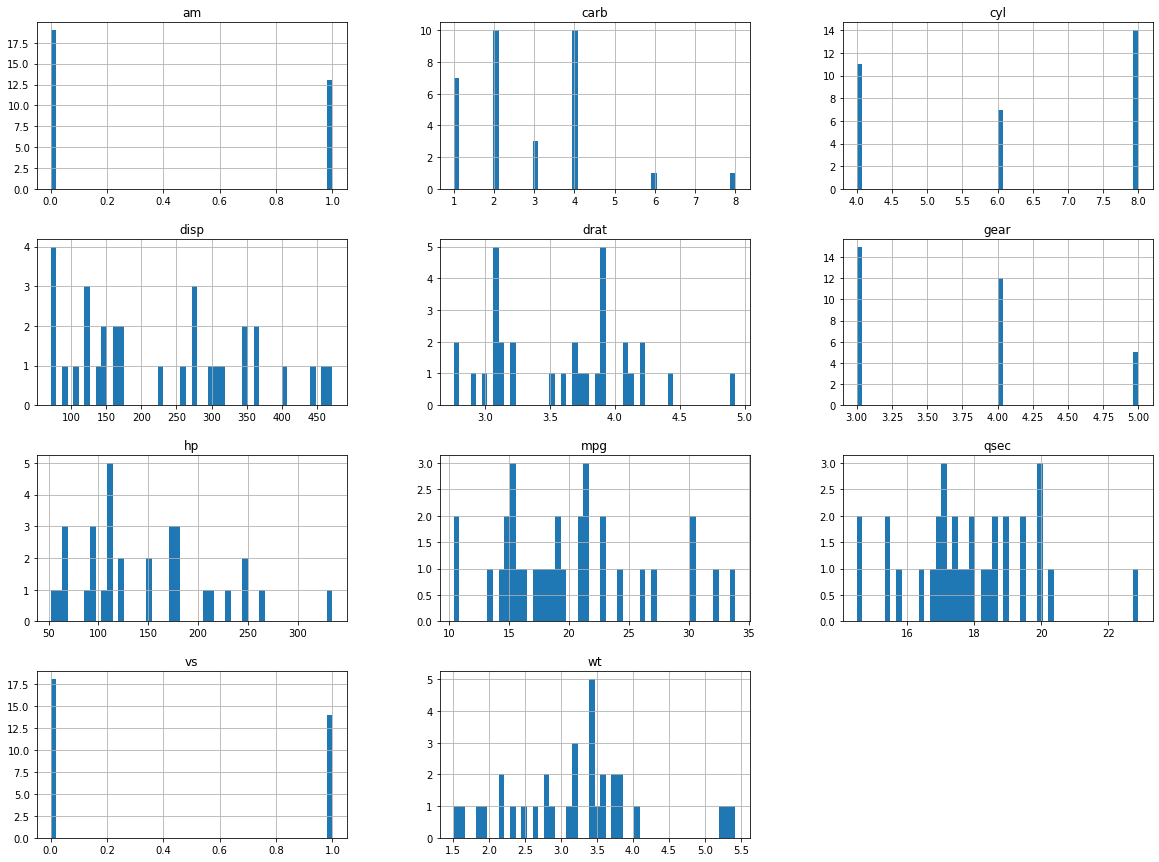

In [14]:
data_all.hist(bins=50, figsize=(20,15))
plt.show()

> The histograms are not skewed. The scales of variation of attribute values are not largely different. Therefore, feature transformation and scaling are skipped in this activity to adopt simplified approach.

> **Some Observations**:
- Less than 25% cars have mpg higher than 22.8.
- The dataset carries more information about manual cars compared to automatic cars (“am” column)
- Most of the cars have upto 4 carburators (“carb” column)
- We have more data for 8-cylinder cars compared to others (“cyl” column)
- at least 75% of the cars have 3 or 4 gears
- Cars with higher hp has lower mpg
- Cars with 8 cylinders have higher horsepower


# 3. Create Test Set

> It is very important not to consider the test set data while selecting features and algorithms to avoid the “data snooping bias”. If we find any interesting pattern from the whole dataset and use that information to select features or algorithms, the model might work well with test set data, but will most likely to fail to generalise well for any new input. For that reason, I separated the test set data (test_set variable) at the very beginning and used it only for final model validation.

In [15]:
train_set, test_set = train_test_split(data_all, test_size=0.2, random_state=10)

> Random sampling is generally used when the dataset is large enough. Still for this activity, random sampling is adopted for the sake of simplicity while splitting data . 

>However, stratified sampling, based on most significant attribute, might be a better choice when the sample size is small.

# 4. Data Insight for Training Set

<Figure size 1440x720 with 0 Axes>

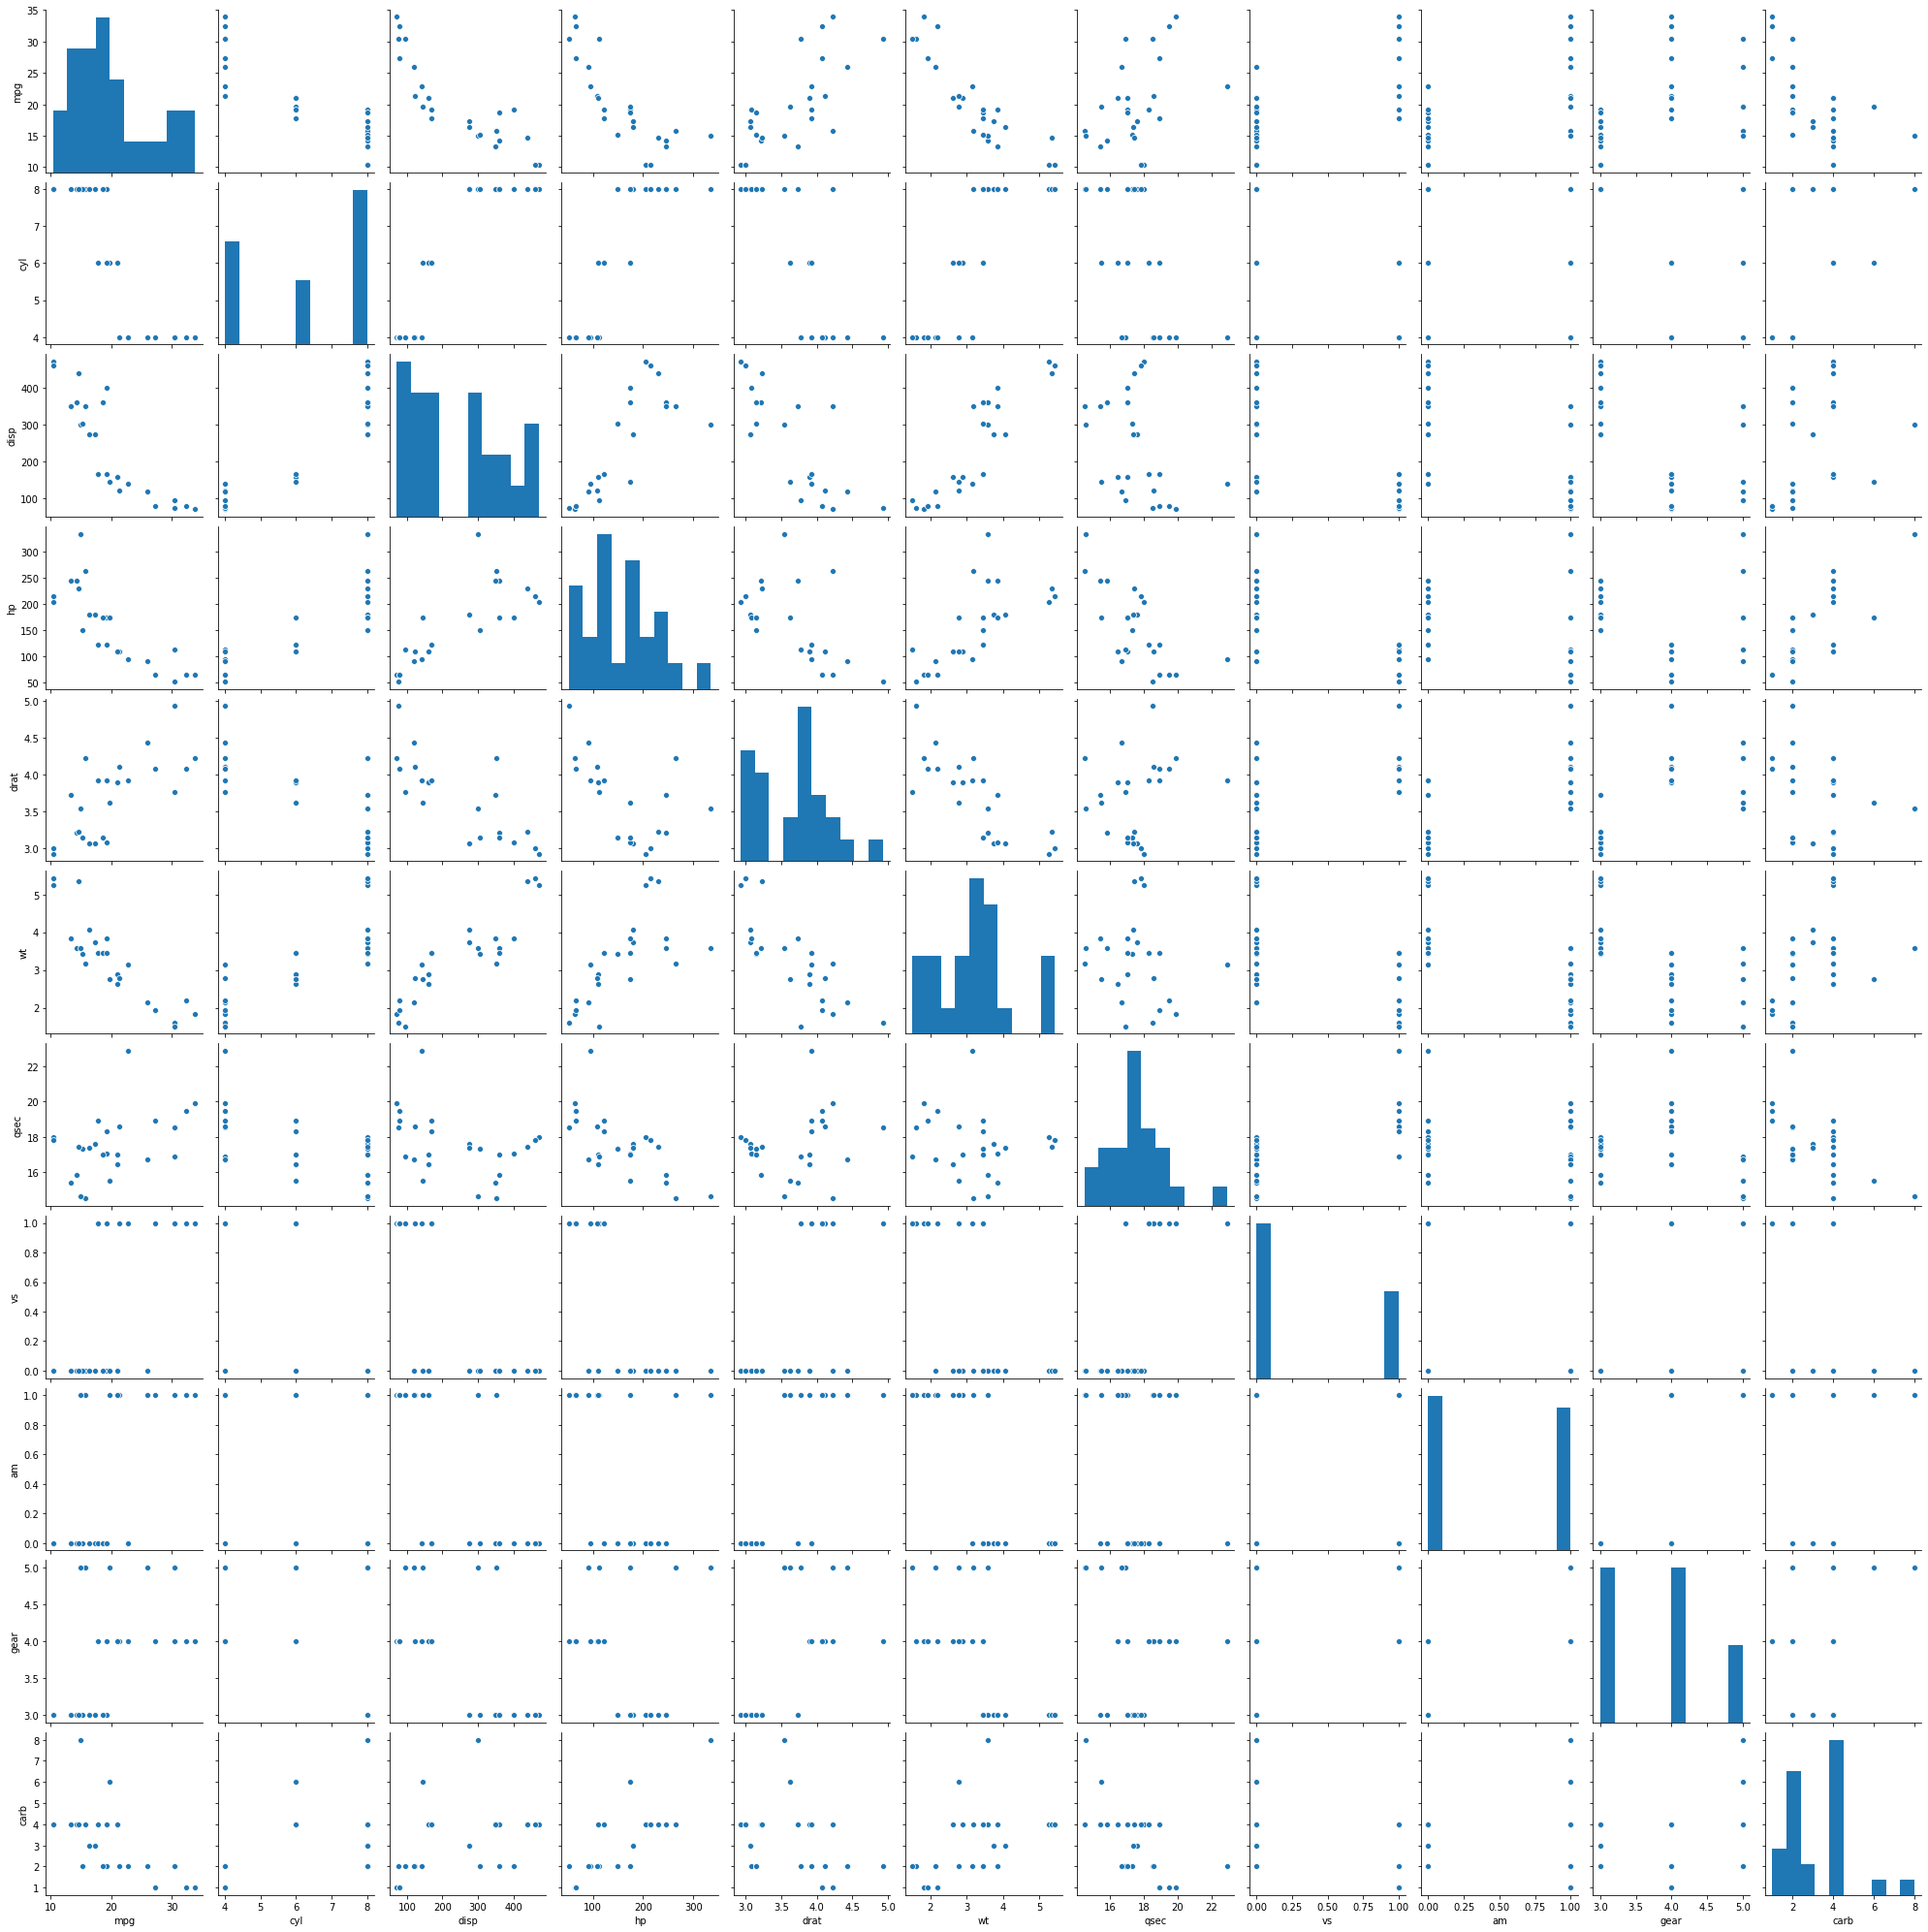

In [16]:
plt.figure(figsize=(20,10))
sns.pairplot(train_set)

> From the scatter plot, it seems mpg is strongly correlated with cyl, disp, and wt. The relations of mpg with hp and drat are also evident. If we include all these features in our model training, we might get better result.

> However, for this exercise, since at most 3 features can be considered, I need to identify 3 features which will influence the model prediction most.

## 4.1 Data Preparation

In [17]:
data = train_set.copy()

## 4.2 Feature Engineering: Experiment with Feature Combination

In [18]:
data["hp_per_disp"] = data["hp"]/data["disp"]
data["wt_per_disp"] = data["wt"]/data["disp"]
data["qsec_per_drat"] = data["qsec"]/data["drat"]

In [19]:
# Prepare Data for feature selection
X = data.drop(["mpg","car"], axis=1)
y = data['mpg'].copy()
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=10)

## 4.3 Feature Selection

### Correlation Method

In [20]:
corr_matrix = data.corr()
corr_matrix

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,hp_per_disp,wt_per_disp,qsec_per_drat
mpg,1.000000,-0.874597,-0.857883,-0.801091,0.711052,-0.881102,0.438871,0.697300,0.647926,0.477327,-0.620871,0.475515,0.773365,-0.386584
cyl,-0.874597,1.000000,0.907314,0.841226,-0.786368,0.799668,-0.569591,-0.799242,-0.629595,-0.558819,0.524219,-0.503983,-0.882372,0.378227
disp,-0.857883,0.907314,1.000000,0.798652,-0.779935,0.892519,-0.409573,-0.723288,-0.664693,-0.610670,0.383912,-0.626312,-0.871693,0.492199
hp,-0.801091,0.841226,0.798652,1.000000,-0.586227,0.674359,-0.679741,-0.691209,-0.353511,-0.182020,0.737982,-0.104204,-0.806353,0.099232
drat,0.711052,-0.786368,-0.779935,-0.586227,1.000000,-0.776514,0.216238,0.609307,0.707982,0.663902,-0.269763,0.447270,0.669236,-0.776002
wt,-0.881102,0.799668,0.892519,0.674359,-0.776514,1.000000,-0.156901,-0.572873,-0.748107,-0.637644,0.436198,-0.616126,-0.634455,0.637246
qsec,0.438871,-0.569591,-0.409573,-0.679741,0.216238,-0.156901,1.000000,0.697052,-0.144575,-0.153167,-0.606819,-0.160080,0.669084,0.433148
vs,0.697300,-0.799242,-0.723288,-0.691209,0.609307,-0.572873,0.697052,1.000000,0.280224,0.311805,-0.494144,0.374702,0.816838,-0.143576
am,0.647926,-0.629595,-0.664693,-0.353511,0.707982,-0.748107,-0.144575,0.280224,1.000000,0.791727,-0.046269,0.693687,0.493255,-0.752073
gear,0.477327,-0.558819,-0.610670,-0.182020,0.663902,-0.637644,-0.153167,0.311805,0.791727,1.000000,0.194741,0.800981,0.389818,-0.736896


<AxesSubplot:>

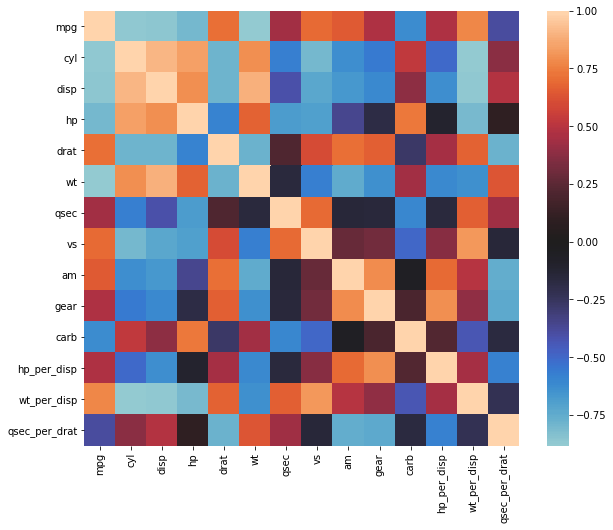

In [21]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, square=True, center=0)

In [22]:
corr_matrix_abs = abs(corr_matrix)
corr_matrix_abs['mpg'].sort_values(ascending=False)

mpg              1.000000
wt               0.881102
cyl              0.874597
disp             0.857883
hp               0.801091
wt_per_disp      0.773365
drat             0.711052
vs               0.697300
am               0.647926
carb             0.620871
gear             0.477327
hp_per_disp      0.475515
qsec             0.438871
qsec_per_drat    0.386584
Name: mpg, dtype: float64

> The "mpg" has very strong linear correlation with all the feature attributes. The most significant three features are "wt", "disp", and "cyl", all of which have negative correlation with "mpg".

> However, Pearson correlation coefficient is not a good indicator of non-linear relationships

In [23]:
features_corr = ["wt", "disp", "cyl"] # selected based on correlation
X_corr = X[features_corr]
base_model = Lasso(alpha=0.1)
get_mse_score(base_model, X_corr, y, 3) # 3-fold cross-validation

MSE - Mean:  3.3871448398262642  - Standard deviation:  0.2418780678134014


array([3.24531742, 3.72763458, 3.18848252])

In [24]:
get_R2_score(X_train[features_corr], X_val[features_corr], y_train, y_val)

R^2 for training data:  0.8528958642069467
R^2 for validation data:  0.7689942631431508


### Select K Best Features

In [25]:
selector = SelectKBest(mutual_info_regression, k=3)
X_new = selector.fit_transform(X_train, y_train)
# X_new

In [26]:
selected_features = pd.DataFrame(selector.inverse_transform(X_new),index=X_train.index,columns=X_train.columns)
selected_features.head()

,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,hp_per_disp,wt_per_disp,qsec_per_drat
11,8.0,275.8,180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,8.0,304.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.0,360.0,175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,4.0,71.1,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,6.0,145.0,175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


>Mutual Information based regression selects 3 important features: "cyl", "disp", "wt" - same as Pearson Correlation based technique

In [27]:
best3_features = ["cyl", "disp", "wt"]
X_best3 = X[best3_features]
base_model = Lasso(alpha=0.1)
get_mse_score(base_model, X_best3, y, 3)

MSE - Mean:  3.3868545103441634  - Standard deviation:  0.241338160573448


array([3.24531423, 3.72658733, 3.18866197])

In [28]:
get_R2_score(X_train[best3_features], X_val[best3_features], y_train, y_val)

R^2 for training data:  0.8528958642069469
R^2 for validation data:  0.7689942631431506


### Feature Importance Method

>Permutation importance randomly shuffles a single column. Model accuracy should suffer if it heavily relies on the shuffled column

In [29]:
model = RandomForestRegressor(n_estimators=50, random_state=10)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=10)

In [30]:
perm_imp = PermutationImportance(model, random_state=10).fit(X_val, y_val)
eli5.show_weights(perm_imp, feature_names=X_val.columns.to_list())

Weight,Feature
0.1697 ± 0.2390,hp
0.1402 ± 0.0910,disp
0.1087 ± 0.0486,wt
0.0347 ± 0.0630,cyl
0.0279 ± 0.0127,qsec
0.0101 ± 0.0281,vs
0.0096 ± 0.0323,wt_per_disp
0.0052 ± 0.0043,carb
0.0020 ± 0.0048,gear
-0.0001 ± 0.0147,qsec_per_drat


>By randomly shuffling each column one-at-a-time, the top 3 significant features are "wt", "disp", and "hp"

In [31]:
perm_features = ["wt", "disp", "hp"]
X_perm = X[perm_features]
base_model = Lasso(alpha=0.1)
get_mse_score(base_model, X_perm, y, 3) 

MSE - Mean:  3.153693796666724  - Standard deviation:  0.35629415796107816


array([2.65208442, 3.36315464, 3.44584233])

In [32]:
get_R2_score(X_train[perm_features], X_val[perm_features], y_train, y_val)

R^2 for training data:  0.8419057790670417
R^2 for validation data:  0.7501038050928752


> 

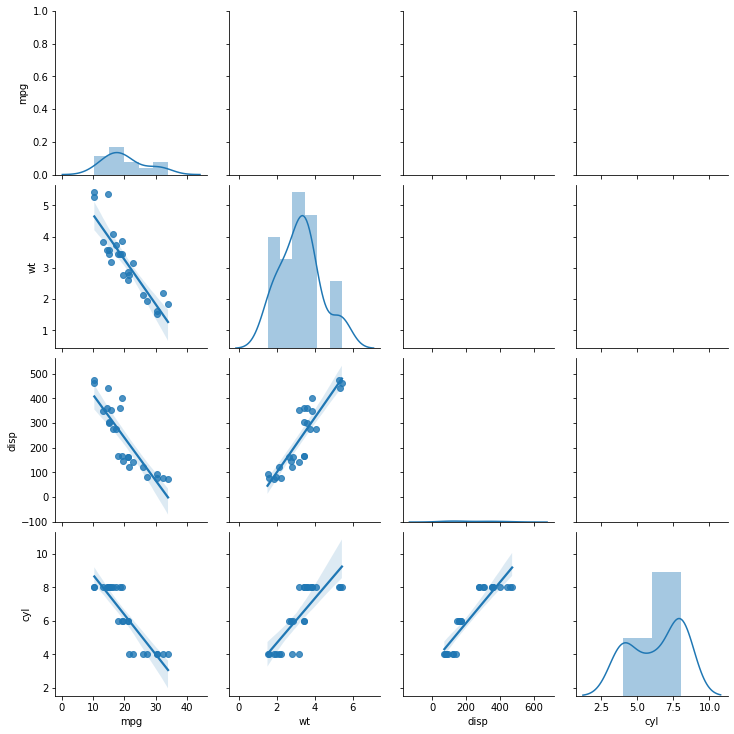

In [33]:
scatter_features = ["mpg","wt", "disp", "cyl"]
# scatter_matrix(data[scatter_features], figsize=(12,10))

#data.plot(kind="scatter", x="wt", y="mpg")

graph_pair = sns.PairGrid(data[scatter_features])
graph_pair.map_diag(sns.distplot)
graph_pair.map_lower(sns.regplot)

>For simplicity, I'll be using the correlation based principle and select features based on that technique. 

>Feature scaling and transformation are also avoided since the range of data for each feature is not significantly disperse.

>Data imputation is not required since we have no missing data.

>Since we discarted the insignificant "car" column, we don't need to do categorical encoding.

# 5. Model Selection

> For the demonstration purpose, I have tested with three different models to identify the base algorithm

In [34]:
# Define model. Specifing a number for random state to ensure same results on each run
model_list = []
model_list.append(('DecisionTreeRegressor', DecisionTreeRegressor(random_state=10)))
model_list.append(('LinearRegression', LinearRegression()))
model_list.append(('RandomForestRegressor', RandomForestRegressor(random_state=10)))

results = []
names = []
for name, model in model_list: #(model_dtr, model_linr, model_ranf, model_svr):
    print()
    print(name) # , model.get_params()
    score = get_mse_score(model, X_corr, y, 5) # 5-fold cross-validation
    get_mse_score_tv(model, X_train[features_corr], X_val[features_corr], y_train, y_val)
    results.append(score)
    names.append(name)


DecisionTreeRegressor
MSE - Mean:  2.8191505437671642  - Standard deviation:  0.9327326581487868
MSE for training data:  0.0
MSE for validation data:  15.40285714285714

LinearRegression
MSE - Mean:  2.667083889076941  - Standard deviation:  0.6260302236272794
MSE for training data:  5.093276390534758
MSE for validation data:  8.267648178078703

RandomForestRegressor
MSE - Mean:  2.264357406763936  - Standard deviation:  0.43467854588824817
MSE for training data:  1.2080134999999743
MSE for validation data:  5.279911142857102


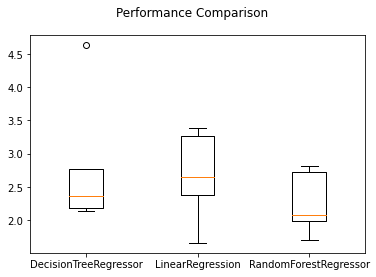

In [35]:
fig = plt.figure()
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

- Decision Tree: overfits the data
    
- Linear Regression: Unknown fit - possibly need to re-evaluate data splitting method, or adding more data and features

- Random Forest: best performance

# 6. Model Fine-Tuning

In [36]:
rand_forest_reg = RandomForestRegressor(random_state=10)

param_grid = [
    {'n_estimators':[3, 5, 8, 10, 30, 50, 100], 'bootstrap': [True, False], 'max_leaf_nodes': [2, 4, 8, 16]}
]

grid_search = GridSearchCV(rand_forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_corr, y)
print("Best Parameter Set: ", grid_search.best_params_)

Best Parameter Set:  {'bootstrap': True, 'max_leaf_nodes': 8, 'n_estimators': 30}


In [37]:
# cv_results = grid_search.cv_results_

# for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
#     print(np.sqrt(-mean_score), params)

# 7. Evaluate on Test Set

In [38]:
final_model = grid_search.best_estimator_
X_test = test_set.drop("mpg", axis=1)
y_test = test_set["mpg"].copy()
X_test_corr = X_test[features_corr]
y_test_predict = final_model.predict(X_test_corr)

get_mse_score(final_model, X_test_corr, y_test, 3) 
# since the size of test_data is small, 3-fold cross-validation is used

final_mse = mean_squared_error(y_test, y_test_predict)
final_rmse = np.sqrt(final_mse)
print("MSE (without cross-validation): ", final_rmse)

MSE - Mean:  2.3830679299183504  - Standard deviation:  1.402021100882794
MSE (without cross-validation):  2.602440641877806


In [39]:
feature_importance = pd.DataFrame(index=X_test_corr.columns, data=final_model.feature_importances_, columns=['Importance'])
feature_importance.sort_values(by='Importance', ascending=False)

,Importance
disp,0.497423
wt,0.412746
cyl,0.089831


<AxesSubplot:>

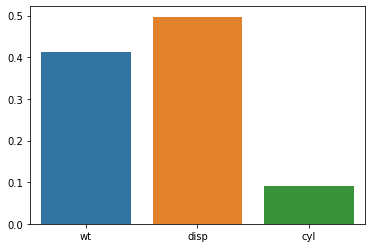

In [40]:
sns.barplot(x=feature_importance.index.to_list(), y=feature_importance.values.ravel())